# 多周期信号加权策略

本策略将使用同一个信号在不同周期的加权平均，来构造总体的信号。

目前使用的是ema和ma的交叉。

In [6]:
import Neilyst

# 回测时间为2023年一年
start_time = '2023-01-01T00:00:00Z'
end_time = '2023-01-02T00:00:00Z'
symbol = 'BTC/USDT'

# 获取数据
data_1h = Neilyst.get_klines(symbol, start_time, end_time, timeframe='15m')
data_30m = Neilyst.get_klines('BTC/USDT', start_time, end_time, timeframe='30m')
data_15m = Neilyst.get_klines('BTC/USDT', start_time, end_time, timeframe='15m')
data_5m = Neilyst.get_klines('BTC/USDT', start_time, end_time, timeframe='5m')
data_1m = Neilyst.get_klines('BTC/USDT', start_time, end_time, timeframe='1m')

In [7]:
# 计算指标

indicators_1h = Neilyst.get_indicators(data_1h, 'sma20', 'ema9')
indicators_30m = Neilyst.get_indicators(data_30m, 'sma20', 'ema9')
indicators_15m = Neilyst.get_indicators(data_15m, 'sma20', 'ema9')
indicators_5m= Neilyst.get_indicators(data_5m, 'sma20', 'ema9')
indicators_1m= Neilyst.get_indicators(data_1m, 'sma20', 'ema9')

In [8]:
class MultiSignalStrategy(Neilyst.Strategy):
    def __init__(self, total_balance, trading_fee_ratio, slippage_ratio, data=None, indicators=None):
        super().__init__(total_balance, trading_fee_ratio, slippage_ratio, data, indicators)
        self.take_profit_ratio = 0.2 #止盈比例
        self.stop_loss_ratio = -0.1 #止损比例
    
    def run(self, date, price_row, current_pos, current_balance):
        recent_data_15m = self.get_recent_data(date, 2, data_1h, indicators_1h)
        signal = None
        
        if len(recent_data_15m) >= 2:
            ema_15 = recent_data_15m.iloc[-1]['ema9']
            ma_15 = recent_data_15m.iloc[-1]['sma20']

            prev_ema_15 = recent_data_15m.iloc[0]['ema9']
            prev_ma_15 = recent_data_15m.iloc[0]['sma20']

            # 先处理信号
            index = 0
            if (ema_15 > ma_15) and (prev_ema_15 < prev_ma_15):
                # 多信号
                index = -1
            if (ema_15 < ma_15) and (prev_ema_15 > prev_ma_15):
                index = 1

            if current_pos.amount > 0:
                # 此时有仓位，考虑平仓过程

                # 先看信号是否翻转
                if current_pos.dir == 'long':
                    # 此时多仓
                    if ema_15 <= ma_15:
                        signal = Neilyst.Signal('close', price_row['close'], current_pos.amount)
                
                if current_pos.dir == 'short':
                    if ema_15 >= ma_15:
                        signal = Neilyst.Signal('close', price_row['close'], current_pos.amount)

                # 固定止盈止损、或者布林带止盈，ma止损
                open_total_price = current_pos.open_price * current_pos.amount
                if (current_pos.float_profit / open_total_price) >= self.take_profit_ratio:
                    #止盈
                    signal = Neilyst.Signal('close', price_row['close'], current_pos.amount)
                elif (current_pos.float_profit / open_total_price) <= self.stop_loss_ratio:
                    #止损
                    signal = Neilyst.Signal('close', price_row['close'], current_pos.amount)

            else:
                # 没有仓位，考虑开仓信号

                # 根据信号计算仓位
                pos = abs(current_balance / price_row['close'] * index)

                # 开仓
                if index > 0:
                    signal = Neilyst.Signal('long', price_row['close'], pos)
                elif index < 0:
                    signal = Neilyst.Signal('short', price_row['close'], pos)

        return signal
    
    # 仓位管理，考虑写入框架的策略：网格
    def pos_management(self):
        pass

In [9]:
init_balance = 50000
strategy = MultiSignalStrategy(init_balance, 0, 0, None, None)
result = Neilyst.backtest(symbol, start_time, end_time, strategy)
evaluation = Neilyst.evaluate_strategy(result, init_balance)

evaluation


 32%|███▏      | 456/1440 [00:00<00:00, 1143.57it/s]/Users/neil/Code/Neilyst/Neilyst/backtest.py:91: RuntimeWarning: invalid value encountered in scalar divide
  'amount': abs(current_pos.pnl / (current_pos.open_price - current_pos.close_price)),
 57%|█████▋    | 821/1440 [00:00<00:00, 1198.12it/s]/Users/neil/Code/Neilyst/Neilyst/backtest.py:91: RuntimeWarning: invalid value encountered in scalar divide
  'amount': abs(current_pos.pnl / (current_pos.open_price - current_pos.close_price)),
/Users/neil/Code/Neilyst/Neilyst/backtest.py:91: RuntimeWarning: invalid value encountered in scalar divide
  'amount': abs(current_pos.pnl / (current_pos.open_price - current_pos.close_price)),
/Users/neil/Code/Neilyst/Neilyst/backtest.py:91: RuntimeWarning: invalid value encountered in scalar divide
  'amount': abs(current_pos.pnl / (current_pos.open_price - current_pos.close_price)),
100%|██████████| 1440/1440 [00:01<00:00, 1175.51it/s]

总收益: -277.9049667879253
总胜率: 0.4375
盈亏比: 0.17608290130492574
最大回撤: 293.9405890236013
年化收益率: 0%
夏普比率: -10.219367965841107


{'total_pnl': -277.9049667879253,
 'win_rate': 0.4375,
 'profit_loss_ratio': 0.17608290130492574,
 'max_drawdown': 293.9405890236013,
 'annual_return': 0,
 'sharpe_ratio': -10.219367965841107}

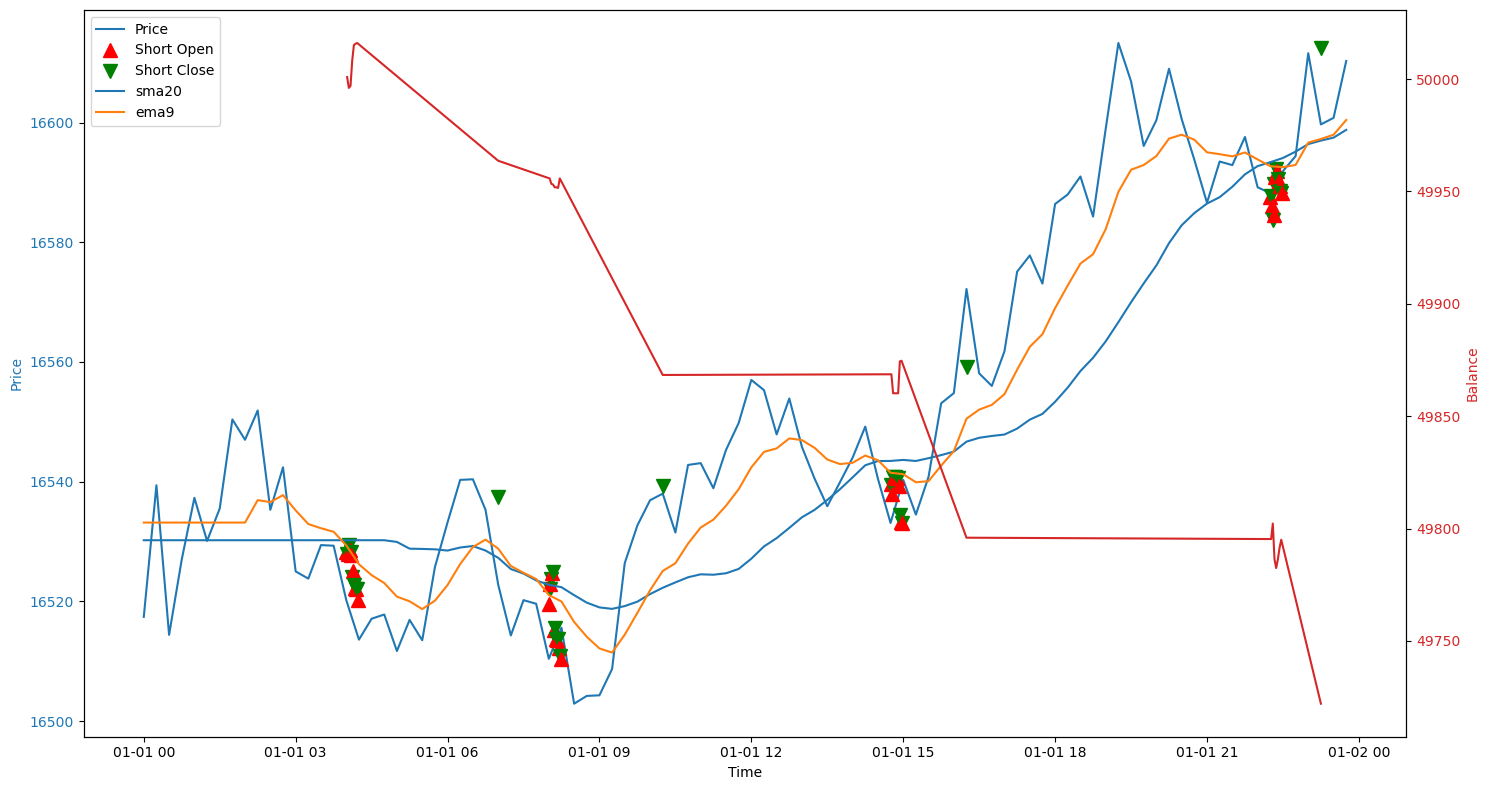

In [10]:
Neilyst.show_pnl(data_15m, indicators_15m, result, init_balance)